In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

In [17]:
df = pd.read_csv('../data/ml_features_subset.csv')
df.columns

Index(['date', 'spike_30', 'past_spikes_30', 'wind_speed', 'precipitation',
       'hdd', 'cdd', 'past_da_load_error', 'past_da_price_error', 'month',
       'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio'],
      dtype='object')

In [18]:
df.set_index('date', inplace= True)

In [19]:
gaussian = ['wind_speed']
uniform = ['hour', 'month']
skewed = ['hdd', 'cdd', 'past_spikes_30', 'precipitation', 'load_capacity_ratio', 'past_da_load_error', 'past_da_price_error']

In [20]:
# Create transformers
gaussian_transformer = StandardScaler()
uniform_transformer = MinMaxScaler()
skewed_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

In [21]:
preprocessor = ColumnTransformer(transformers=[
    ('gaussian', gaussian_transformer, gaussian),
    ('uniform', uniform_transformer, uniform),
    ('skewed', skewed_transformer, skewed)
])


In [22]:
transformed_data = preprocessor.fit_transform(df)

# Convert back to DataFrame with original column names
transformed_df = pd.DataFrame(
    transformed_data,
    columns=gaussian + uniform + skewed
)

In [23]:
df['past_da_load_error'] = np.log1p(df['past_da_load_error'])
df['past_da_price_error'] = np.log1p(df['past_da_price_error'])
df['hdd'] = np.log1p(df['hdd'])
df['cdd'] = np.log1p(df['cdd'])


In [24]:
df.describe()

,spike_30,past_spikes_30,wind_speed,precipitation,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
count,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000,34674.000000
mean,0.071177,1.709379,12.316286,0.151087,1.558591,0.531317,13.568691,8.913746,6.556815,11.501413,0.284017,0.001327,0.997916
std,0.257124,2.956868,6.997229,1.410741,1.235523,0.843887,1.293064,1.521387,3.452445,6.921857,0.450951,0.036399,0.276648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.981788,5.208440,1.000000,0.000000,0.000000,0.000000,0.001225
25%,0.000000,0.000000,6.877790,0.000000,0.000000,0.000000,12.648927,7.847813,4.000000,6.000000,0.000000,0.000000,0.800131
50%,0.000000,1.000000,11.113451,0.000000,1.953382,0.000000,13.489316,8.719529,7.000000,12.000000,0.000000,0.000000,0.911688
75%,0.000000,2.000000,16.622490,0.000000,2.708217,1.193165,14.419465,9.779424,10.000000,18.000000,1.000000,0.000000,1.133028
max,1.000000,24.000000,52.211170,63.400000,3.569603,2.959976,17.496724,15.712578,12.000000,23.000000,1.000000,1.000000,6.555103


In [25]:
transformed_df.describe()

,wind_speed,hour,month,hdd,cdd,past_spikes_30,precipitation,load_capacity_ratio,past_da_load_error,past_da_price_error
count,3.467400e+04,34674.000000,34674.000000,3.467400e+04,3.467400e+04,3.467400e+04,3.467400e+04,3.467400e+04,3.467400e+04,3.467400e+04
mean,-3.311522e-16,0.500061,0.505165,5.245975e-17,-1.967241e-16,5.901722e-17,-6.598453e-17,6.000084e-16,1.291821e-15,6.623044e-16
std,1.000014e+00,0.300950,0.313859,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.760192e+00,0.000000,0.000000,-1.261501e+00,-6.296156e-01,-8.393276e-01,-2.009652e-01,-5.267164e+00,-3.547365e+00,-2.435514e+00
25%,-7.772469e-01,0.260870,0.272727,-1.261501e+00,-6.296156e-01,-8.393276e-01,-2.009652e-01,-7.374394e-01,-7.113162e-01,-7.006426e-01
50%,-1.719041e-01,0.521739,0.545455,3.195384e-01,-6.296156e-01,6.680767e-02,-2.009652e-01,-2.731641e-01,-6.138612e-02,-1.276601e-01
75%,6.154245e-01,0.782609,0.818182,9.304905e-01,7.842965e-01,5.968628e-01,-2.009652e-01,5.727781e-01,6.579619e-01,5.690140e-01
max,5.701609e+00,1.000000,1.000000,1.627684e+00,2.877985e+00,3.368634e+00,1.510688e+01,1.033806e+01,3.037816e+00,4.468902e+00


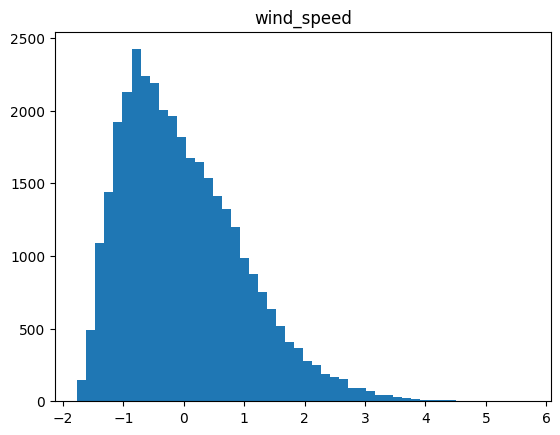

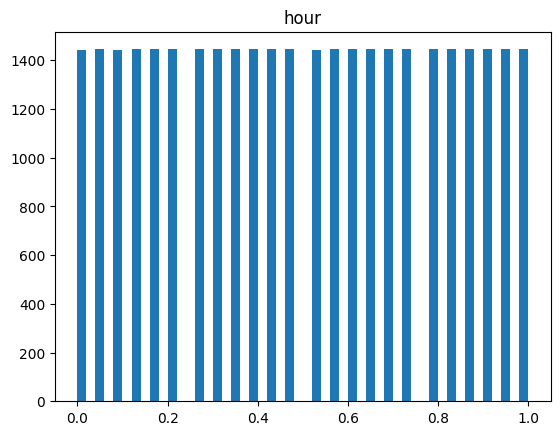

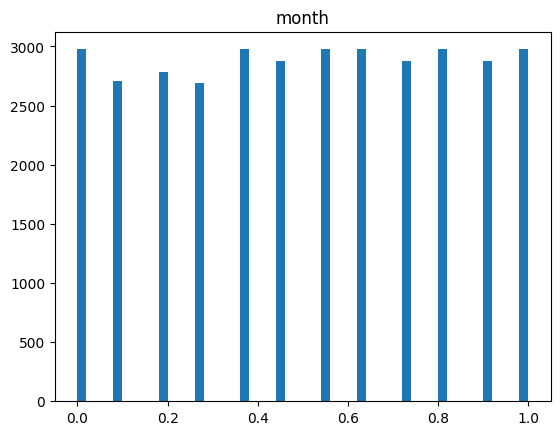

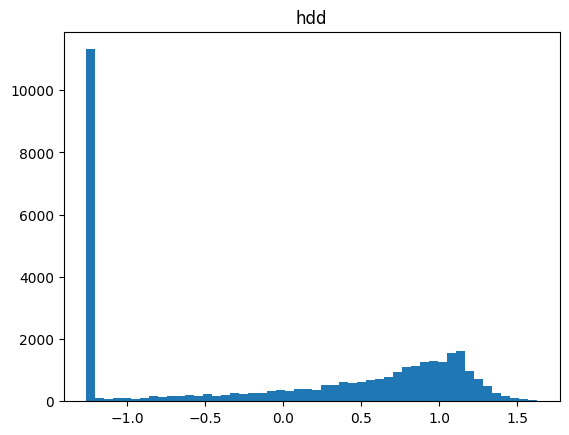

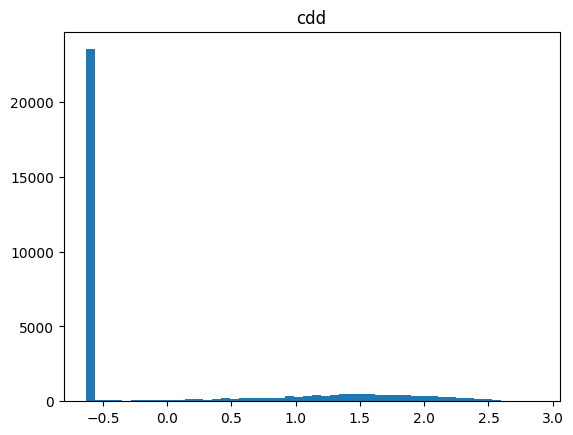

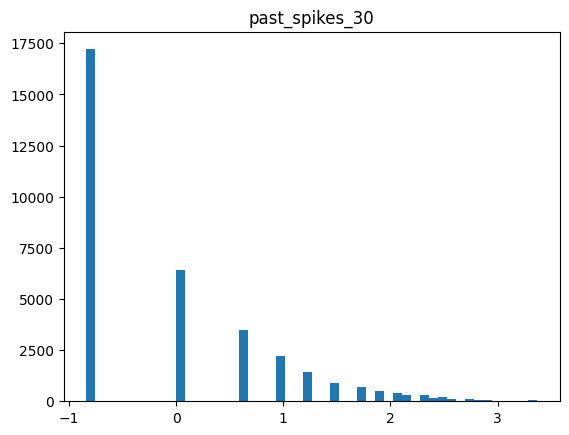

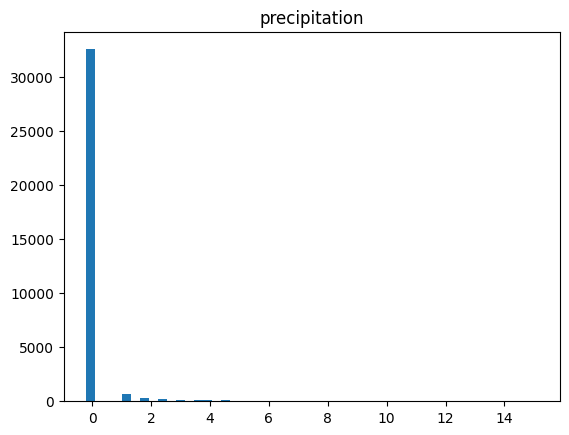

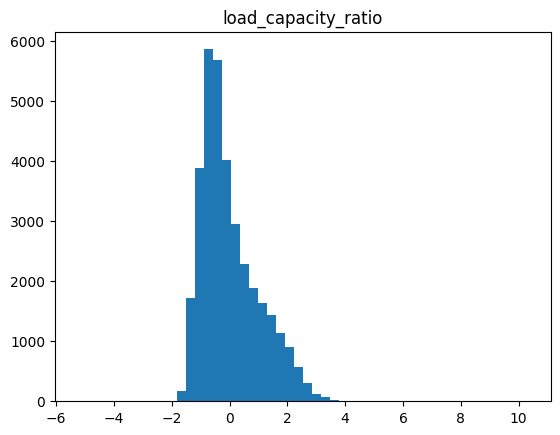

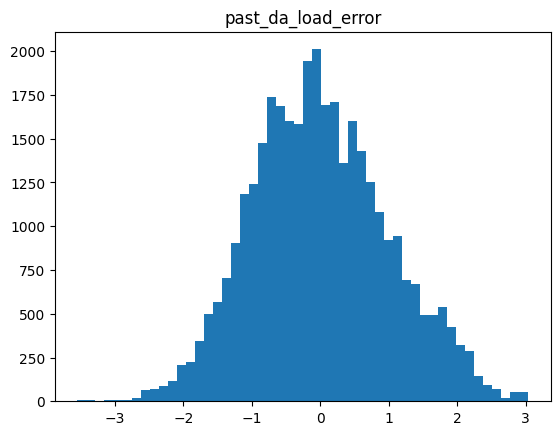

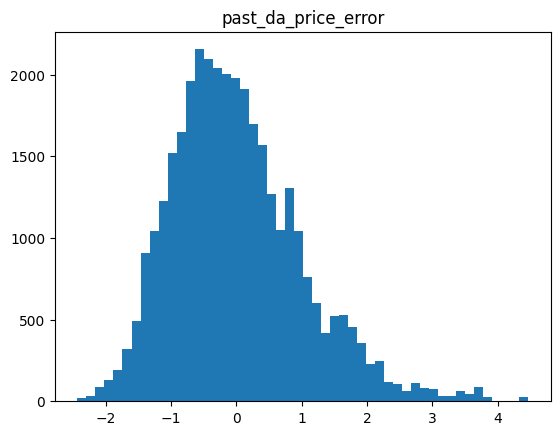

In [28]:
for col in transformed_df.columns:
    plt.hist(transformed_df[col], bins= 50)
    plt.title(col)
    plt.show()

In [27]:
idx = df['load_capacity_ratio'].argmax()
print(df['da_prices'].shift(24).iloc[idx])
print(df['da_prices'].iloc[idx-24])

KeyError: 'da_prices'

In [ ]:
idx = df['load_capacity_ratio'].argmax()
pd.set_option('display.float_format', '{:.5f}'.format)
print(df.index[idx-24], df['da_prices'].shift(24).iloc[idx])
print(df.index[idx], df['rt_prices'].iloc[idx])

2019-12-11 13:00:00 35.5
2019-12-12 13:00:00 30.2675
